In [1]:
# 필요 모듈 로딩
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import FinanceDataReader as fdr
import pandas_datareader as pdr
import pandas_datareader.data as web
import yfinance as yf

from module import stationarity_adf_test, stationarity_kpss_test

from IPython.display import display_html
def display_side_by_side(*args):
    """여러 데이터프레임 비교가 쉽게 옆쪽으로 표시한다"""
    html_str=''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)

# 공적분 

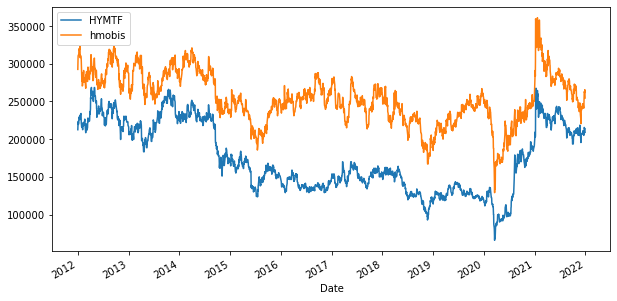

,output
statistics,-3.75
p-value,0.02


In [2]:
import datetime

# 데이터 로딩(2012~2022)
start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2022, 1, 1)
HYMTF = web.DataReader("005380.KS", 'yahoo', start, end)
hmobis = web.DataReader("012330.KS", 'yahoo', start, end)
raw = pd.concat([HYMTF.Close, hmobis.Close], axis=1).dropna()
raw.columns = ['HYMTF', 'hmobis']

# 주가 시각화
raw.plot(figsize=(10,5))
plt.show()

# sm.tsa.coint로 공적분 관계 파악
coint_result = sm.tsa.coint(raw.HYMTF, raw.hmobis)
pd.DataFrame([coint_result[0], coint_result[1]], index=['statistics', 'p-value'], columns=['output'])

In [3]:
# 현대차와 현대모비스에 로그를 씌운 변수 추가
raw['log_HYMTF'] = np.log(raw.HYMTF)
raw['log_hmobis'] = np.log(raw.hmobis)

# 로그씌우고 1차 차분 추가
raw['log_HYMTF_diff'] = raw.log_HYMTF.diff(1).dropna()
raw['log_hmobis_diff'] = raw.log_hmobis.diff(1).dropna()

# 결측치 제거
raw = raw.dropna()
raw

,HYMTF,hmobis,log_HYMTF,log_hmobis,log_HYMTF_diff,log_hmobis_diff
Date,,,,,,
2012-01-03,"221,500.00","303,500.00",12.31,12.62,0.04,0.04
2012-01-04,"223,500.00","309,500.00",12.32,12.64,0.01,0.02
2012-01-05,"223,500.00","311,000.00",12.32,12.65,0.00,0.00
2012-01-06,"219,500.00","311,000.00",12.30,12.65,-0.02,0.00
2012-01-09,"221,500.00","312,500.00",12.31,12.65,0.01,0.00
...,...,...,...,...,...,...
2021-12-24,"215,500.00","263,000.00",12.28,12.48,0.03,0.03
2021-12-27,"213,500.00","261,500.00",12.27,12.47,-0.01,-0.01
2021-12-28,"214,000.00","265,500.00",12.27,12.49,0.00,0.02


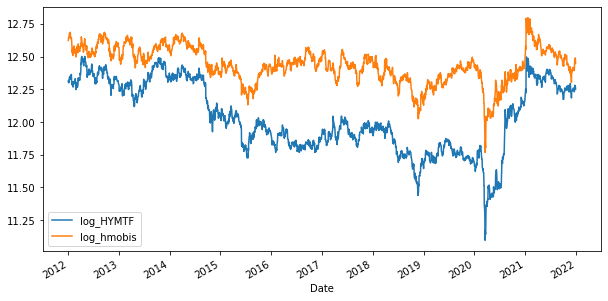

In [4]:
# 로그를 씌운 데이터 시각화
raw[['log_HYMTF', 'log_hmobis']].plot(figsize=(10,5))
plt.show()

In [5]:
# 로그 씌운 현대자동차 주가 비정상성 테스트
display(pd.Series(sm.tsa.stattools.adfuller(raw['log_HYMTF'],regression = 'nc', maxlag=3, autolag=None)[0:4], 
                  index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations']))

# 로그 씌운 현대모비스 주가 비정상성 테스트
display(pd.Series(sm.tsa.stattools.adfuller(raw['log_hmobis'],regression = 'nc', maxlag=3, autolag=None)[0:4], 
                  index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations']))

# 로그를 씌운 현재자동차 및 현대모비스는 단위근을 가지고 있다.

Test Statistics        -0.09
p-value                 0.65
Used Lag                3.00
Used Observations   2,457.00
dtype: float64

Test Statistics        -0.24
p-value                 0.60
Used Lag                3.00
Used Observations   2,457.00
dtype: float64

                            OLS Regression Results                            
Dep. Variable:             log_hmobis   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     5663.
Date:                Sun, 19 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:12:41   Log-Likelihood:                 2848.7
No. Observations:                2461   AIC:                            -5693.
Df Residuals:                    2459   BIC:                            -5682.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.2650      0.069    105.705      0.0

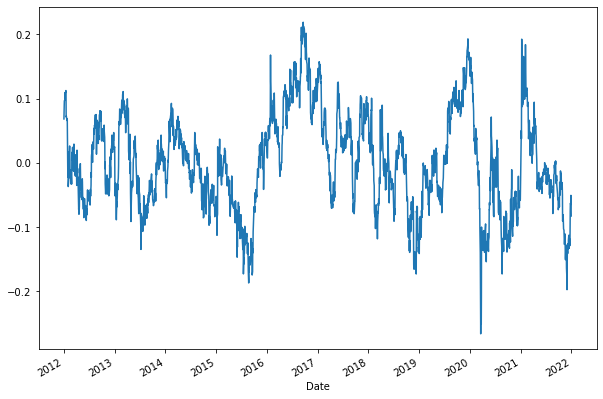

Test Statistics        -4.92
p-value                 0.00
Used Lag                2.00
Used Observations   2,458.00
dtype: float64

In [6]:
# 장기 탄력성 확인
# 현대차와 현대모비스에 로그를 씌우고 OLS 회귀분석
# 현대모비스가 종속변수, 현대 자동차가 독립변수
model = smf.ols('log_hmobis~log_HYMTF', data=raw).fit()
print(model.summary())

# 회귀식의 잔차 시각화
plt.figure(figsize=(10,7))
model.resid.plot()
plt.show()

# 회귀식 잔차 비정상성 테스트
display(pd.Series(sm.tsa.stattools.adfuller(model.resid)[0:4], 
                  index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations']))

In [7]:
# model에서 나온 잔차항을 e_hat으로 추가
# e_hat에 shift(1)을 적용한 e_hat_shift1 추가
raw['e_hat'] = model.resid
raw['e_hat_shift1'] = raw.e_hat.shift(1)
raw = raw.dropna()
raw

,HYMTF,hmobis,log_HYMTF,log_hmobis,log_HYMTF_diff,log_hmobis_diff,e_hat,e_hat_shift1
Date,,,,,,,,
2012-01-04,"223,500.00","309,500.00",12.32,12.64,0.01,0.02,0.08,0.07
2012-01-05,"223,500.00","311,000.00",12.32,12.65,0.00,0.00,0.09,0.08
2012-01-06,"219,500.00","311,000.00",12.30,12.65,-0.02,0.00,0.10,0.09
2012-01-09,"221,500.00","312,500.00",12.31,12.65,0.01,0.00,0.10,0.10
2012-01-10,"226,500.00","318,500.00",12.33,12.67,0.02,0.02,0.11,0.10
...,...,...,...,...,...,...,...,...
2021-12-24,"215,500.00","263,000.00",12.28,12.48,0.03,0.03,-0.06,-0.07
2021-12-27,"213,500.00","261,500.00",12.27,12.47,-0.01,-0.01,-0.06,-0.06
2021-12-28,"214,000.00","265,500.00",12.27,12.49,0.00,0.02,-0.05,-0.06


                            OLS Regression Results                            
Dep. Variable:        log_hmobis_diff   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     1023.
Date:                Sun, 19 Jun 2022   Prob (F-statistic):          4.94e-324
Time:                        13:12:41   Log-Likelihood:                 6789.7
No. Observations:                2460   AIC:                        -1.357e+04
Df Residuals:                    2457   BIC:                        -1.356e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -5.469e-05      0.000     -0.

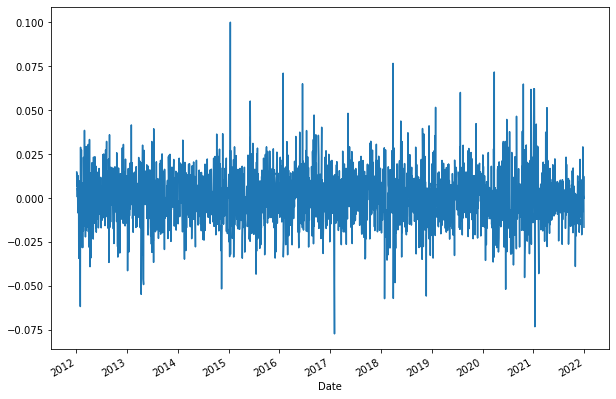

Test Statistics       -37.33
p-value                 0.00
Used Lag                1.00
Used Observations   2,458.00
dtype: float64

In [8]:
# 단기탄력성 및 오차수정항 파악
# 현대차와 현대모비스에 로그를 씌우고 차분한 다음 OLS 회귀분석
# 현대모비스가 종속변수, 현대자동차가 독립변수
model = smf.ols('log_hmobis_diff~log_HYMTF_diff+e_hat_shift1', data=raw).fit()
print(model.summary())

# 회귀식의 잔차 시각화
plt.figure(figsize=(10,7))
model.resid.plot()
plt.show()

# 회귀식 잔차 비정상성 테스트
display(pd.Series(sm.tsa.stattools.adfuller(model.resid)[0:4], 
                  index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations']))

In [9]:
import statsmodels.stats.diagnostic as dg

# 보통 lag는 3으로 많이 씁니다.(이서진 교수님 왈)
# 귀무가설 : Autocorrelation이 없다.
# 대립가설 : Autocorrelation이 있다.
# 자기상관도 없다.
dg.acorr_breusch_godfrey(model, nlags=3)

(9.343358051952091,
 0.025057503830014028,
 3.118701639255813,
 0.02509337505388038)

# Granger Causality

,HYMTF,hmobis,log_HYMTF,log_hmobis,log_HYMTF_diff,log_hmobis_diff,e_hat,e_hat_shift1
Date,,,,,,,,
2012-01-04,"223,500.00","309,500.00",12.32,12.64,0.01,0.02,0.08,0.07
2012-01-05,"223,500.00","311,000.00",12.32,12.65,0.00,0.00,0.09,0.08
2012-01-06,"219,500.00","311,000.00",12.30,12.65,-0.02,0.00,0.10,0.09
2012-01-09,"221,500.00","312,500.00",12.31,12.65,0.01,0.00,0.10,0.10
2012-01-10,"226,500.00","318,500.00",12.33,12.67,0.02,0.02,0.11,0.10
...,...,...,...,...,...,...,...,...
2021-12-24,"215,500.00","263,000.00",12.28,12.48,0.03,0.03,-0.06,-0.07
2021-12-27,"213,500.00","261,500.00",12.27,12.47,-0.01,-0.01,-0.06,-0.06
2021-12-28,"214,000.00","265,500.00",12.27,12.49,0.00,0.02,-0.05,-0.06


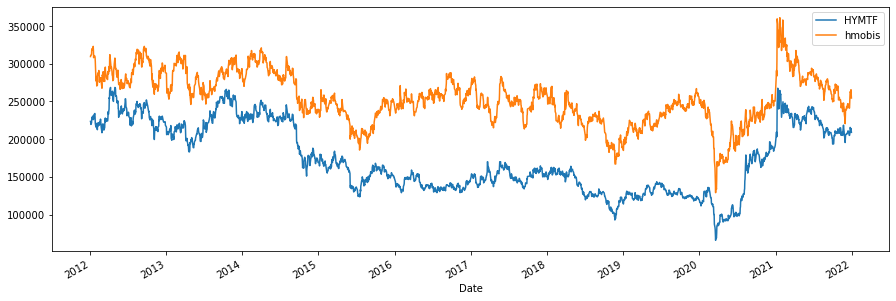

In [10]:
# 데이터 셋 로딩 및 주가 시각화
display(raw)
raw[['HYMTF', 'hmobis']].plot(figsize=(15,5))
plt.show()

In [11]:
# 데이터 adf테스트
# regression = 'nc', maxlag=3로 해줌
display(pd.Series(sm.tsa.stattools.adfuller(raw.HYMTF, regression = 'nc', maxlag=3, autolag=None)[0:4], 
                  index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations']))
display(pd.Series(sm.tsa.stattools.adfuller(raw.hmobis, regression = 'nc', maxlag=3, autolag=None)[0:4], 
                  index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations']))

# adf테스트 결과 두 데이터는 모두 단위근이 존재

Test Statistics        -0.57
p-value                 0.47
Used Lag                3.00
Used Observations   2,456.00
dtype: float64

Test Statistics        -0.73
p-value                 0.40
Used Lag                3.00
Used Observations   2,456.00
dtype: float64

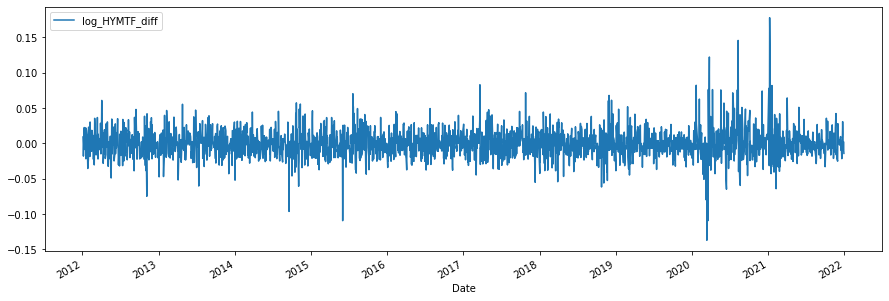

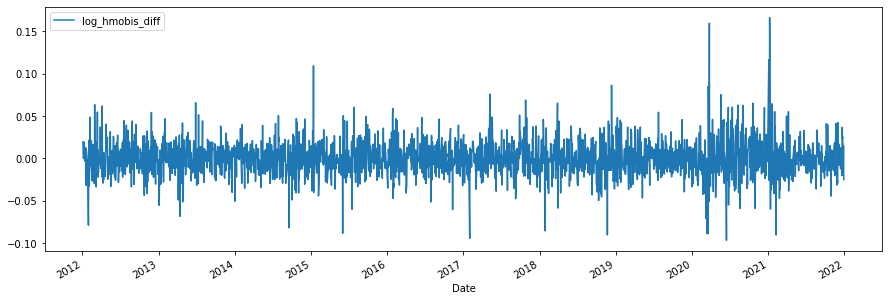

Test Statistics       -24.17
p-value                 0.00
Used Lag                3.00
Used Observations   2,456.00
dtype: float64

Test Statistics       -25.33
p-value                 0.00
Used Lag                3.00
Used Observations   2,456.00
dtype: float64

In [12]:
# 데이터 변환 후 시각화 및 adf테스트
raw[['log_HYMTF_diff']].plot(figsize=(15,5))
raw[['log_hmobis_diff']].plot(figsize=(15,5))
plt.show()

display(pd.Series(sm.tsa.stattools.adfuller(raw.log_HYMTF_diff, regression = 'nc', maxlag=3, autolag=None)[0:4], 
                  index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations']))
display(pd.Series(sm.tsa.stattools.adfuller(raw.log_hmobis_diff, regression = 'nc', maxlag=3, autolag=None)[0:4], 
                  index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations']))

# adf테스트 결과 정상성 확보

In [13]:
granger_raw = raw[['log_HYMTF_diff', 'log_hmobis_diff']]
granger_raw

,log_HYMTF_diff,log_hmobis_diff
Date,,
2012-01-04,0.01,0.02
2012-01-05,0.00,0.00
2012-01-06,-0.02,0.00
2012-01-09,0.01,0.00
2012-01-10,0.02,0.02
...,...,...
2021-12-24,0.03,0.03
2021-12-27,-0.01,-0.01
2021-12-28,0.00,0.02


In [16]:
# 로그씌우고 차분한 데이터로 
print('\n[현대모비스 -> 현대차]')
granger_result1 = sm.tsa.stattools.grangercausalitytests(granger_raw.values, maxlag = 4, verbose=True)
print('\n[현대차 -> 현대모비스]')
granger_result2 = sm.tsa.stattools.grangercausalitytests(granger_raw.iloc[:, [1,0]].values, maxlag=4, verbose=True)


[현대모비스 -> 현대차]

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0275  , p=0.8682  , df_denom=2456, df_num=1
ssr based chi2 test:   chi2=0.0276  , p=0.8681  , df=1
likelihood ratio test: chi2=0.0276  , p=0.8681  , df=1
parameter F test:         F=0.0275  , p=0.8682  , df_denom=2456, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0158  , p=0.9843  , df_denom=2453, df_num=2
ssr based chi2 test:   chi2=0.0317  , p=0.9843  , df=2
likelihood ratio test: chi2=0.0317  , p=0.9843  , df=2
parameter F test:         F=0.0158  , p=0.9843  , df_denom=2453, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1183  , p=0.9494  , df_denom=2450, df_num=3
ssr based chi2 test:   chi2=0.3559  , p=0.9492  , df=3
likelihood ratio test: chi2=0.3558  , p=0.9492  , df=3
parameter F test:         F=0.1183  , p=0.9494  , df_denom=2450, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         